<div align="center"; span style="color:#336699"><b><h2>Chapter 5.3 - Global Census of Precipitation Systems</h2></b></div>
<hr style="border:2px solid #0077b9;">
<br/>
<div style="text-align: center;font-size: 90%;">
   <sup><a href="https://www.linkedin.com/in/helvecio-leal/"> Helvecio B. Leal Neto, <i class="fab fa-lg fa-orcid" style="color: #a6ce39"></i></a></sup><t>&nbsp;</t>
    <sup><a href="https://www.linkedin.com/in/alan-calheiros-64a252160/">Alan J. P. Calheiros, <i class="fab fa-lg fa-orcid" style="color: #a6ce39"></i></a></sup>
   <br/><br/>
    National Institute for Space Research (INPE)
    <br/>
    Avenida dos Astronautas, 1758, Jardim da Granja, São José dos Campos, SP 12227-010, Brazil
    <br/><br/>
    Contact: <a href="mailto:helvecio.neto@inpe.br">helvecio.neto@inpe.br</a>, <a href="mailto:alan.calheiros@inpe.br">alan.calheiros@inpe.br</a>
    <br/><br/>
    Last Update: December 2, 2024
</div>
<br/>
<div style="text-align: justify;  margin-left: 25%; margin-right: 25%;">
<b>Abstract.</b> This Jupyter Notebook presents a comprehensive global census of tracked precipitation systems (PSs) from GSMaP-MKV v8 and IMERG Final V07 datasets for the 2015–2024 period. The analysis examines spatial distributions, temporal variability, seasonal patterns, and inter-dataset differences. Global maps reveal hotspots of precipitation system activity, while time series analysis identifies trends and seasonal cycles. Hovmöller diagrams illustrate latitudinal migration patterns of precipitation systems throughout the year, providing insights into large-scale atmospheric circulation and tropical-extratropical interactions.
</div>    
<br/>
<div style="text-align: justify;  margin-left: 15%; margin-right: 15%;font-size: 75%; border-style: solid; border-color: #0077b9; border-width: 1px; padding: 5px;">
    <b>This analysis provides a global perspective on precipitation system occurrence, comparing two independent satellite products to identify regions of agreement and divergence. The results contribute to understanding global precipitation patterns, seasonal variability, and product-specific uncertainties in precipitation system tracking.
</b>
</div>

### Schedule
 [1. Environment Setup and Library Imports](#setup)<br>
 [2. Database Connection](#database)<br>
 [3. Dataset Configuration](#config)<br>
 [4. Load Tracking Tables](#loadtables)<br>
 [5. Load Spatial Tracking Data](#loadspatial)<br>
 [6. Global Spatial Distribution Maps](#spatial)<br>
 [7. Regional Analysis and Divergence Investigation](#regional)<br>
 [8. Temporal Analysis and Census](#temporal)<br>
 [9. Seasonal Distribution Maps](#seasonal)<br>
 [10. Dominant Season Analysis](#dominant)<br>
 [11. Hovmöller Diagrams](#hovmoller)

<a id='setup'></a>
#### 1. Environment Setup and Library Imports

This section initializes the notebook environment and imports all necessary libraries for global precipitation system analysis:

**Core Libraries**:
- **autoreload**: Automatically reloads custom modules during development
- **os**: Operating system interface for file path operations
- **numpy & pandas**: Numerical computing and data manipulation
- **xarray**: Multi-dimensional labeled arrays for NetCDF data handling
- **geopandas**: Geospatial data structures and operations

**Visualization Libraries**:
- **matplotlib.pyplot & patches & colors**: Core plotting and visual styling
- **seaborn**: Statistical data visualization
- **cartopy**: Geospatial data processing and map projections
- **gridspec**: Advanced subplot layout control

**Custom Modules**:
- **plots**: Specialized functions for precipitation system visualization
- **utils**: Database connection, data loading, and spatial analysis utilities
  - `createDuckCon`: Creates configured DuckDB database connection
  - `loadTrackingTable`: Loads tracking tables with filtering
  - `loadSpatialTracking`: Loads gridded spatial datasets
  - `point2retPolygon`: Creates rectangular polygons from point coordinates
  - `hotspots_dataset`: Identifies precipitation hotspots

**Utilities**:
- **calendar**: Month name operations for temporal plotting
- **ProgressBar**: Dask progress monitoring for long computations

In [1]:
%reload_ext autoreload
%autoreload 2
import os
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import seaborn as sns
import cartopy
import calendar
import plots
import matplotlib.gridspec as gridspec
from dask.diagnostics import ProgressBar
from utils import createDuckCon, loadTrackingTable, loadSpatialTracking, point2retPolygon, hotspots_dataset

ProgressBar().register()

<a id='database'></a>
#### 2. Database Connection

Create a persistent DuckDB database connection for efficient querying of large tracking datasets.

Unlike the in-memory database used in previous analyses, this creates a file-based database at `/prj/cptec/helvecio.leal/tmp/glob_sensus.duckdb` to handle the extensive queries required for global census analysis. The `createDuckCon()` function configures the connection with optimized settings for parallel processing, spatial operations, and large memory allocation.

In [2]:
# Create DuckDB connection
con = createDuckCon("/prj/cptec/helvecio.leal/tmp/glob_sensus.duckdb")

<a id='config'></a>
#### 3. Dataset Configuration

Define dataset names and file paths for both satellite precipitation products:

**Dataset Names**:
- **GSMaP-MKV v8**: Global Satellite Mapping of Precipitation - Microwave-IR Combined Product version 8
- **IMERG Final V07**: Integrated Multi-satellitE Retrievals for GPM Final Run version 07

**Tracking Table Paths**:
- Contain event-level information (uid, timestamp, duration, geometry, etc.)
- Stored in grouped parquet format for efficient querying
- Pre-filtered for systems with duration ≥ 3 hours

**Spatial NetCDF Paths**:
- Gridded datasets containing spatial density and precipitation values
- Variables include:
  - `fam-density`: Family (system) count per grid cell
  - `clu-values`: Cluster precipitation values
- Monthly temporal resolution covering 2015–2024

In [8]:
# Config dataset names
gsmap_name = "GSMaP-MKV v8"
imerg_name = "IMERG Final V07"

# Set path for the tracking table files
gsmap_trackingtable = '/prj/cptec/helvecio.leal/tracks/gsmap/track/grouped/*.parquet'
imerg_trackingtable = '/prj/cptec/helvecio.leal/tracks/imerg/track/grouped/*.parquet'

# Set paths for the netcdfs files
gsmap_netcdf_path = '/prj/cptec/helvecio.leal/tracks/gsmap/spatial_120_0/'
imerg_netcdf_path = '/prj/cptec/helvecio.leal/tracks/imerg/spatial_120_0/'

<a id='loadtables'></a>
#### 4. Load Tracking Tables into DuckDB

Load and register the tracking tables as DuckDB views for both datasets.

**Filtering Criteria Applied by `loadTrackingTable()`**:
1. **Precipitation Threshold**: 0.1 mm/h (consistent with previous filtering)
2. **Temporal Range**: 2015-01-01 to 2024-12-31 (10 years)
3. **Duration Threshold**: ≥ 120 minutes (2 hours minimum lifetime)

The function creates SQL views named `gsmap_tracking` and `imerg_tracking` that enable efficient querying without loading entire datasets into memory. These views serve as the foundation for temporal analysis and event counting.

In [ ]:
# Load tracking tables into DuckDB
loadTrackingTable(con, gsmap_trackingtable, 'gsmap_tracking')
loadTrackingTable(con, imerg_trackingtable, 'imerg_tracking')

<a id='loadspatial'></a>
#### 5. Load Spatial Tracking Data

Load gridded spatial datasets containing precipitation system density and characteristics.

**Data Structure**:
- **Format**: Multi-file NetCDF datasets opened with xarray
- **Temporal Dimension**: Monthly timesteps from 2015–2024
- **Spatial Coverage**: Global, restricted to -60° to 60° latitude
- **Grid Resolution**: 0.1° × 0.1° (approximately 11 km at the equator)

**Key Variables**:
- **fam-density**: Number of precipitation system families (unique systems) per grid cell per month
- **clu-values**: Mean precipitation values within tracked systems

**Loading Process**:
- Uses `open_mfdataset` for efficient lazy loading with Dask
- HDF5/NetCDF4 engine for compatibility
- Concatenates multiple monthly files along time dimension
- Spatial subsetting excludes polar regions where tracking is less reliable

These datasets enable spatial analysis and visualization of global precipitation system distributions.

In [7]:
gsmap_netcdf_path

'/prj/cptec/helvecio.leal/tracks/gsmap/spatial/'

In [9]:
# Load spatial tracking data
gsmap_ds_v8 = loadSpatialTracking(gsmap_netcdf_path)
imerg_ds_v7 = loadSpatialTracking(imerg_netcdf_path)

Loading spatial tracking data from: /prj/cptec/helvecio.leal/tracks/gsmap/spatial_120_0/
Loading spatial tracking data from: /prj/cptec/helvecio.leal/tracks/imerg/spatial_120_0/


<a id='spatial'></a>
### Part 1: Global Spatial Distribution Analysis

This section examines the global spatial patterns of precipitation system occurrence, comparing distributions between GSMaP and IMERG datasets and identifying regions of high activity.

#### 6. Calculate Total System Counts

Compute the total number of precipitation systems per grid cell over the entire 2015–2024 period.

**Calculation**:
- **Operation**: Sum of `fam-density` across all monthly timesteps
- **Output**: Total system count per 0.1° grid cell over 10 years
- **skipna=True**: Ignores missing values (ocean areas, data gaps)
- **compute()**: Triggers Dask computation and loads results into memory

**Interpretation**:
The resulting arrays reveal global hotspots of precipitation system activity, showing where systems most frequently occur. High values indicate regions with persistent convective activity or frequent storm passage, while low values suggest more arid or stable atmospheric conditions.

#### Figure 5.3 - Global map showing the count of tracked PSs for the 2015–2024 period, with a minimum duration filter of 3 hours.

#### 6.1. Visualize Global Precipitation System Distribution

Create a two-panel global map showing the spatial distribution of tracked precipitation systems for both datasets.

**Figure 5.3 - Global PS Count Maps (2015–2024)**

**Map Configuration**:
- **Panel (a)**: GSMaP-MKV v8 system counts
- **Panel (b)**: IMERG Final V07 system counts
- **Projection**: Cylindrical Equidistant (PlateCarree)
- **Spatial Extent**: -60° to 60° latitude, global longitude coverage

**Visual Elements**:
- **Colormap**: 'terrain_r' (reverse terrain) with 30 discrete levels
- **Color Scale**: Logarithmic-like distribution from 10 to 10,000 systems
- **Features**: Coastlines, country borders, and latitude density shading
- **Colorbar**: Shared scale for direct comparison, labeled "PS Count"

**Key Patterns to Observe**:
- **Tropical Convergence Zones**: ITCZ, SPCZ showing maximum activity
- **Monsoon Regions**: South Asia, West Africa, South America
- **Storm Tracks**: Mid-latitude regions with high system counts
- **Oceanic vs. Continental**: Differences in system frequency
- **Orographic Effects**: Mountain ranges influencing system development

**Scientific Interpretation**:
The maps reveal the global distribution of convective and stratiform precipitation systems, highlighting regions where organized precipitation is most common. Differences between panels indicate product-specific sensitivities in system detection and tracking.

In [10]:
gsmap_fam_count = gsmap_ds_v8['fam-density'].sum(dim='time', skipna=True).compute()
imerg_fam_count = imerg_ds_v7['fam-density'].sum(dim='time', skipna=True).compute()

[########################################] | 100% Completed | 5.35 sms
[########################################] | 100% Completed | 1.41 sms


<a id='regional'></a>
### Part 2: Inter-Dataset Divergence Analysis

This section investigates regional differences between GSMaP and IMERG system counts, identifying areas of agreement and divergence.

#### 7. Calculate Inter-Dataset Differences

Compute the difference in system counts between IMERG and GSMaP datasets.

**Calculation**:
- **Formula**: diff = IMERG_count - GSMaP_count
- **Positive Values**: IMERG detects more systems than GSMaP
- **Negative Values**: GSMaP detects more systems than IMERG
- **Zero/Near-Zero**: Good agreement between products

**Purpose**:
Identifying divergence patterns helps understand product-specific biases, detection sensitivities, and retrieval algorithm differences. Large discrepancies may indicate regions where one product performs better or where precipitation characteristics challenge tracking algorithms.

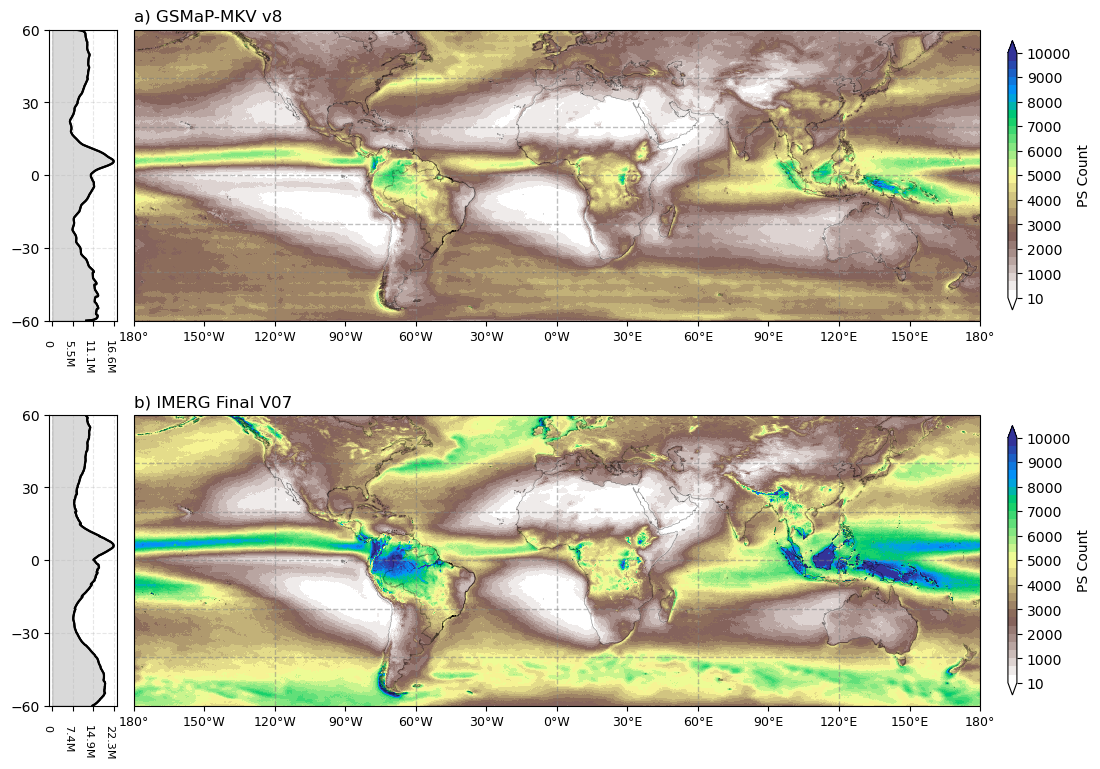

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10), dpi=100, subplot_kw={'projection': cartopy.crs.PlateCarree()})
fig.subplots_adjust(hspace=0.0001)
plots.map(gsmap_fam_count, figsize=(12, 12), ax=axes[0],
    title='', lat_density=True,
    cbar_label='PS Count', cmap='terrain_r', cmap_num=30, ylim=[-60, 60],
    cbar_extend='both', max_val=10000, min_val=10, cbar_fraction=0.06,  cbar_shrink=0.7, 
    cbar_ticks=[10, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000])
plots.map(imerg_fam_count,figsize=(12, 12), ax=axes[1],
    title='', lat_density=True,
    cbar_label='PS Count', cmap='terrain_r', cmap_num=30, ylim=[-60, 60],
    cbar_extend='both', max_val=10000, min_val=10, cbar_fraction=0.06,  cbar_shrink=0.7, 
    cbar_ticks=[10, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000])
axes[0].set_title("a) " + gsmap_name, loc='left', y=1)
axes[1].set_title("b) " + imerg_name, loc='left', y=1);

##### Figure 5.4 - Difference between the frequency count of the tracked SPs.

#### 7.1. Define Region of Interest for Investigation

Create a rectangular region centered on the Amazon basin for detailed investigation of inter-dataset differences.

**Region Parameters**:
- **Center Point**: Latitude -2.5°, Longitude -55° (Central Amazon)
- **Spatial Extent**: 500 km × 500 km square region
- **Function**: `point2retPolygon()` creates a polygon from center coordinates and dimensions

**Purpose**:
This region is selected based on observed divergence in the global difference map. Detailed analysis of this area helps understand:
- Temporal patterns of disagreement between products
- Whether differences are systematic or seasonal
- Potential causes related to precipitation regime or land surface characteristics

The region will be used to extract time series of system counts and precipitation values for both datasets.

In [11]:
# Difference between the frequency count of the tracked SPs
diff = (imerg_fam_count - gsmap_fam_count)

In [12]:
# Define a region to investigate
lat = -2.5
lon = -55
dx_km = 500
dy_km = 500
geo_investigate = gpd.GeoDataFrame(geometry=[point2retPolygon(lat, lon, dx_km, dy_km)], crs="EPSG:4326")

#### 7.2. Extract Regional Time Series

Extract and process monthly time series of system counts and precipitation values within the region of interest.

**Processing Steps**:

1. **Spatial Clipping**:
   - Assign CRS (EPSG:4326 - WGS84) to the datasets
   - Rename coordinates ('lat'/'lon' → 'y'/'x') for rioxarray compatibility
   - Clip data to the defined rectangular region using `rio.clip()`

2. **Variables Extracted**:
   - **fam-density**: Monthly count of precipitation systems in the region
   - **clu-values**: Mean precipitation intensity within tracked systems
   
3. **Temporal Aggregation**:
   - Sum system counts across all grid cells in the region
   - Average precipitation values across space
   - Maintain monthly temporal resolution

4. **IMERG Adjustment**:
   - Multiply precipitation by 0.5 to convert from 30-minute to hourly rates
   - Ensures comparable units with GSMaP (mm/h)

**Output**:
- `gsmap_reg_series_fam_density`: Monthly PS counts (GSMaP)
- `imerg_reg_series_fam_density`: Monthly PS counts (IMERG)
- `gsmap_reg_precip_series`: Monthly mean precipitation (GSMaP)
- `imerg_reg_precip_series`: Monthly mean precipitation (IMERG)

These time series enable detailed temporal comparison within the investigation region.

In [ ]:
# Investigate fam-density GSMAP
gsmap_reg_series_fam_density = gsmap_ds_v8['fam-density']
gsmap_reg_series_fam_density = gsmap_reg_series_fam_density.rio.write_crs("EPSG:4326")
gsmap_reg_series_fam_density = gsmap_reg_series_fam_density.rename({"lat": "y", "lon": "x"})
gsmap_reg_series_fam_density = gsmap_reg_series_fam_density.rio.clip(geo_investigate.geometry, geo_investigate.crs)
gsmap_reg_series_fam_density = gsmap_reg_series_fam_density.sum(dim=['y', 'x'], skipna=True).compute()
# Investigate fam-density IMERG
imerg_reg_series_fam_density = imerg_ds_v7['fam-density']
imerg_reg_series_fam_density = imerg_reg_series_fam_density.rio.write_crs("EPSG:4326")
imerg_reg_series_fam_density = imerg_reg_series_fam_density.rename({"lat": "y", "lon": "x"})
imerg_reg_series_fam_density = imerg_reg_series_fam_density.rio.clip(geo_investigate.geometry, geo_investigate.crs)
imerg_reg_series_fam_density = imerg_reg_series_fam_density.sum(dim=['y', 'x'], skipna=True).compute()
# Get Precipitation Values from Clusters of GSMAP
gsmap_reg_precip_values = gsmap_ds_v8['clu-values']
gsmap_reg_precip_values = gsmap_reg_precip_values.rio.write_crs("EPSG:4326")
gsmap_reg_precip_values = gsmap_reg_precip_values.rename({"lat": "y", "lon": "x"})
gsmap_reg_precip_values = gsmap_reg_precip_values.rio.clip(geo_investigate.geometry, geo_investigate.crs)
gsmap_reg_precip_series = (gsmap_reg_precip_values).mean(dim=['y','x'], skipna=True).compute()
# Get Precipitation Values from Clusters of IMERG
imerg_reg_precip_values = imerg_ds_v7['clu-values']
imerg_reg_precip_values = imerg_reg_precip_values.rio.write_crs("EPSG:4326")
imerg_reg_precip_values = imerg_reg_precip_values.rename({"lat": "y", "lon": "x"})
# Multiply by 30 min diff
imerg_reg_precip_values = imerg_reg_precip_values.rio.clip(geo_investigate.geometry, geo_investigate.crs) * 0.5 
imerg_reg_precip_series = (imerg_reg_precip_values).mean(dim=['y','x'], skipna=True).compute()

#### 7.3. Visualize Difference Map and Regional Analysis

**Figure 5.4 - Inter-Dataset Divergence Investigation**

Create a comprehensive three-panel figure examining differences between IMERG and GSMaP:

**Panel (a) - Global Difference Map**:
- **Data**: IMERG system count minus GSMaP system count
- **Colormap**: 'coolwarm' (blue = GSMaP higher, red = IMERG higher)
- **Range**: -3,000 to +3,000 systems
- **Features**: 
  - Latitude density comparison between datasets
  - Green rectangle showing the investigation region
  - Divergent colormap centered at zero

**Panel (b) - Regional Monthly System Counts**:
- **Time Series**: Monthly PS counts within the investigation region
- **Lines**: GSMaP (blue) and IMERG (orange)
- **Background**: Seasonal shading (DJF, MAM, JJA, SON)
- **Y-axis**: Count displayed in thousands (k notation)
- **Grid**: Minor ticks for each month, major ticks annually

**Panel (c) - Regional Mean Precipitation**:
- **Time Series**: Monthly spatially-averaged precipitation intensity
- **Lines**: GSMaP (blue dashed) and IMERG (orange dashed)
- **Units**: mm/h
- **Purpose**: Investigate whether count differences correlate with intensity differences

**Legend Elements**:
- Dataset labels (GSMaP-MKV v8, IMERG Final V07)
- Seasonal indicators (DJF = blue, MAM = green, JJA = yellow, SON = pink)
- Combined legend at bottom showing all elements

**Analysis Goal**:
Identify whether inter-dataset differences are:
- Spatially systematic (concentrated in specific regions)
- Temporally consistent or seasonal
- Related to precipitation intensity variations
- Systematic biases or random discrepancies

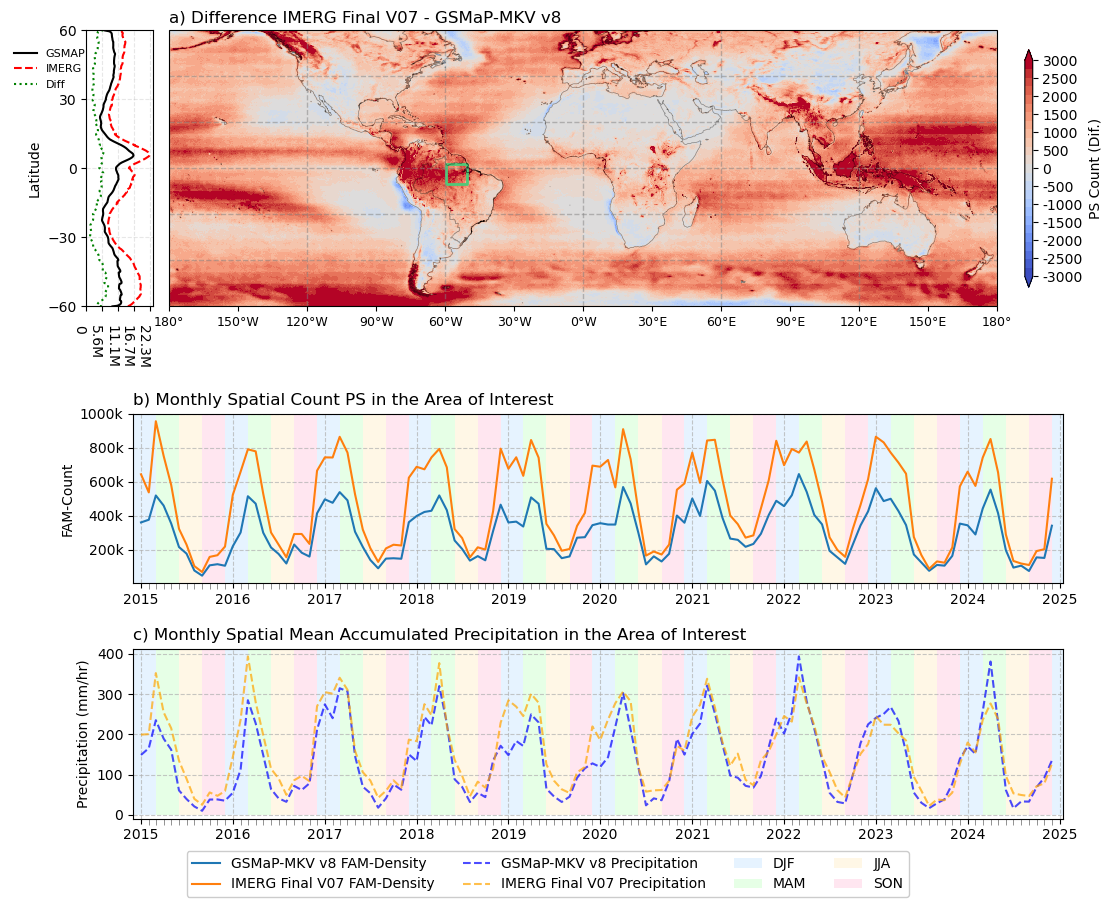

In [22]:
fig = plt.figure(figsize=(12, 10), dpi=100)
gs = gridspec.GridSpec(3, 1, height_ratios=[2, 1, 1], figure=fig)
ax0 = fig.add_subplot(gs[0],projection=cartopy.crs.PlateCarree())
ax1 = fig.add_subplot(gs[1])
ax2 = fig.add_subplot(gs[2])
# Main map
plots.map(diff, figsize=(12, 12), ax=ax0,
    title="Difference " + imerg_name + " - " + gsmap_name, lat_density_diff=True, array1=gsmap_fam_count, array2=imerg_fam_count,
    cbar_label='PS Count (Dif.)', cmap_num=25, cbar_format='%.0f', max_val=3000, min_val=-3000,  cmap='coolwarm',
            cbar_extend='both', cbar_fraction=0.08, ylim=[-60, 60], cbar_ticks=np.arange(-3000, 3500, 500), cbar_shrink=0.7)
# Region
geo_investigate.plot(ax=ax0, facecolor='none', edgecolor='#50c878', linewidth=2, label='Area of Interest')
# Count of events
gsmap_reg_series_fam_density.plot(ax=ax1, label=f'{gsmap_name} FAM-Density')
imerg_reg_series_fam_density.plot(ax=ax1, label=f'{imerg_name} FAM-Density')
# Precip of events
gsmap_reg_precip_series.plot(ax=ax2, color='blue', linestyle='--', label=f'{gsmap_name} Precipitation', alpha=0.7)
imerg_reg_precip_series.plot(ax=ax2, color='orange', linestyle='--', label=f'{imerg_name} Precipitation', alpha=0.7)
# Add patchs for add legend into ax1
handles, labels = ax1.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax1.legend(by_label.values(), by_label.keys())
# Get yticks and Change yticks from ax1, add like 10k, 30k
yticks = ax1.get_yticks()
ax1.set_yticklabels([f'{int(y/1000)}k' for y in yticks])
ax1.set_xticks(gsmap_reg_series_fam_density['time'].values, minor=True)
ax1.tick_params(axis="x", which="minor", length=4, color="gray")
ax1.grid(visible=True, linestyle='--', alpha=0.7)
ax2.set_xticks(gsmap_reg_series_fam_density['time'].values, minor=True)
ax2.tick_params(axis="x", which="minor", length=4, color="gray")
ax2.grid(visible=True, linestyle='--', alpha=0.7)
# Add seasonal backgrounds
extended_start = pd.to_datetime('2014-12-01', format='%Y-%m-%d')
extended_end = pd.to_datetime('2025-01-15', format='%Y-%m-%d')
y_max_vals = [1000000, 10000]
season_colors = plots.add_seasonal_backgrounds([ax1, ax2], extended_start, extended_end, y_max_vals)
# add xlim
ax1.set_xlim([extended_start, extended_end])
ax2.set_xlim([extended_start, extended_end])
# Legend
season_patches = [mpatches.Rectangle((0, 0), 1, 1, facecolor=color, alpha=1) for color in season_colors.values()]
handles_ax1, labels_ax1 = ax1.get_legend_handles_labels()
handles_ax2, labels_ax2 = ax2.get_legend_handles_labels()
ax2.legend(handles_ax1 + handles_ax2 + season_patches, labels_ax1 + labels_ax2 + list(season_colors.keys()), loc='upper left', ncol=4, framealpha=1, bbox_to_anchor=(0.05, -0.15))
ax1.legend_.remove()
# Remove titles and labels
ax1.set_title("")
ax2.set_title("")
ax1.set_xlabel("")
ax2.set_xlabel("")
ax1.set_ylabel("FAM-Count")
ax2.set_ylabel("Precipitation (mm/hr)")
# Add titles
ax0.set_title("a) " + "Difference " + imerg_name + " - " + gsmap_name, loc='left', y=1)
ax1.set_title("b) Monthly Spatial Count PS in the Area of ​​Interest", loc='left', y=1)
ax2.set_title("c) Monthly Spatial Mean Accumulated Precipitation in the Area of Interest", loc='left', y=1)
pos1 = ax1.get_position()
pos2 = ax2.get_position()
ax1.set_position([pos1.x0 - 0.03, pos1.y0 - 0.03, pos1.width, pos1.height])
ax2.set_position([pos2.x0 - 0.03, pos2.y0 - 0.05, pos2.width, pos2.height])

<a id='temporal'></a>
### Part 3: Global Temporal Analysis and Census

This section examines temporal variability in precipitation system occurrence, including monthly time series, seasonal patterns, and long-term trends.

#### 8. Query Event Start Times by Season

Construct a SQL query to aggregate precipitation system counts by year, month, and meteorological season.

**Query Structure**:

1. **Subquery**: Extract the first timestamp (event_start) for each unique system (uid)
   - Identifies system initiation time
   - Groups by uid to get one timestamp per system

2. **Main Query Aggregations**:
   - **COUNT(*)**: Total number of systems per time period
   - **year**: Extract year from event_start using `strftime()`
   - **month**: Extract month (1-12) from event_start
   - **season**: Assign meteorological season:
     - DJF (Dec-Jan-Feb): Austral summer / Boreal winter
     - MAM (Mar-Apr-May): Austral autumn / Boreal spring
     - JJA (Jun-Jul-Aug): Austral winter / Boreal summer
     - SON (Sep-Oct-Nov): Austral spring / Boreal autumn

3. **Grouping**: Results grouped by year, month, and season
4. **Ordering**: Chronologically sorted by year and month

**Purpose**:
This query enables temporal analysis of system occurrence, revealing:
- Annual variability and trends
- Seasonal cycles
- Inter-annual variations in seasonal patterns
- Comparison between datasets

#### Figure 5.5 - Global time series and seasonal census of tracked precipitating systems from GSMaP-MKV v8 and IMERG Final V07 (2015–2024), with mean differences between datasets

#### 8.1. Execute Queries and Merge Results

Execute the temporal aggregation query for both datasets and merge results into a unified DataFrame.

**Processing Steps**:

1. **Execute Queries**:
   - Run query on `gsmap_tracking` table → `gsmap_events`
   - Replace table name and run on `imerg_tracking` → `imerg_events`

2. **Merge DataFrames**:
   - Join on: year, month, season (temporal keys)
   - Suffixes: '_gsmap' and '_imerg' for count columns
   - Result: Side-by-side monthly counts for both datasets

3. **Calculate Difference**:
   - Create 'diff' column: GSMaP count - IMERG count
   - Positive: GSMaP detects more systems
   - Negative: IMERG detects more systems

4. **Create DateTime Index**:
   - Construct date from year and month (day=1)
   - Convert to datetime and set as index
   - Enables time series plotting and analysis

**Output DataFrame Columns**:
- `year`, `month`, `season`: Temporal identifiers
- `count_gsmap`: Monthly system count from GSMaP
- `count_imerg`: Monthly system count from IMERG  
- `diff`: Difference (GSMaP - IMERG)
- `date`: DateTime index for plotting

In [23]:
events_query = f"""
    SELECT 
        COUNT(*) AS count,
        strftime(event_start, '%Y')::INT AS year,
        strftime(event_start, '%m')::INT AS month,
        CASE 
            WHEN strftime(event_start, '%m') IN ('12','01','02') THEN 'DJF'
            WHEN strftime(event_start, '%m') IN ('03','04','05') THEN 'MAM'
            WHEN strftime(event_start, '%m') IN ('06','07','08') THEN 'JJA'
            ELSE 'SON'
        END AS season
    FROM (
        SELECT uid, MIN(timestamp) AS event_start
        FROM gsmap_tracking
        GROUP BY uid
    )
    GROUP BY year, month, season
    ORDER BY year, month
"""

#### 8.2. Visualize Global Time Series and Census

**Figure 5.5 - Global Temporal Analysis (2015–2024)**

Create a comprehensive two-panel figure showing global precipitation system counts and inter-dataset differences:

**Panel (Top) - Monthly Time Series**:
- **Primary Lines**:
  - GSMaP-MKV v8: Blue line with circle markers
  - IMERG Final V07: Orange line with square markers
  - Line width: 2.5 for visibility
  
- **Background Shading**: Seasonal color coding
  - DJF: Light blue (#e6f3ff)
  - MAM: Light green (#e6ffe6)
  - JJA: Light yellow (#fff7e6)
  - SON: Light pink (#ffe6f0)

- **Seasonal Trends**: Dashed lines showing linear trends for each season
  - Color-coded by season
  - Applied separately to each dataset
  - Reveals systematic seasonal changes over the decade

- **Y-axis**: System count range 50,000–230,000
- **Statistics Box**: White background box showing:
  - Total systems per dataset (~M notation)
  - Mean monthly difference ± standard deviation
  - Seasonal totals for both datasets
  - Mean monthly counts by season

**Panel (Bottom) - Monthly Differences**:
- **Bar Chart**: Monthly differences (IMERG - GSMaP)
  - Green bars: IMERG > GSMaP
  - Red bars: GSMaP > IMERG
  - Bar width: 20 days
  
- **Mean Line**: Black dashed horizontal line
  - Shows average difference across all months
  - Annotated with mean value
  
- **Y-axis**: Difference in thousands (-130k to -60k)
- **X-axis**: Shared timeline (2015-2024)

**Key Insights**:
- **Seasonal Cycle**: Clear annual oscillation in system counts
- **Inter-Dataset Bias**: Systematic offset between products
- **Trends**: Potential long-term changes in system frequency
- **Variability**: Inter-annual and seasonal variations

In [24]:
gsmap_events = con.execute(events_query).df()
imerg_events = con.execute(events_query.replace('gsmap_tracking', 'imerg_tracking')).df()
number_of_events = pd.merge(gsmap_events, imerg_events, on=['year', 'month', 'season'], suffixes=('_gsmap', '_imerg'))
number_of_events['diff'] = number_of_events['count_gsmap'] - number_of_events['count_imerg']
number_of_events['date'] = pd.to_datetime(number_of_events[['year', 'month']].assign(day=1))
number_of_events.set_index('date', inplace=True)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

<a id='seasonal'></a>
### Part 4: Seasonal Distribution Analysis

This section examines how precipitation system occurrence varies by meteorological season, revealing regional patterns in seasonal precipitation variability.

#### 9. Separate Data by Season

Subset the spatial datasets into four seasonal groups using xarray's time accessor.

**Seasonal Selection**:
- **JJA** (Jun-Jul-Aug): Austral winter / Boreal summer
- **SON** (Sep-Oct-Nov): Austral spring / Boreal autumn  
- **DJF** (Dec-Jan-Feb): Austral summer / Boreal winter
- **MAM** (Mar-Apr-May): Austral autumn / Boreal spring

**Method**:
- Uses `.sel(time=ds['time.season'] == 'SEASON')` to filter timesteps
- Retains spatial dimensions (lat, lon) and all variables
- Creates 8 seasonal datasets (4 seasons × 2 products)

**Purpose**:
Seasonal subsetting enables analysis of:
- Regional variations in precipitation seasonality
- Differences in seasonal patterns between hemispheres
- Monsoon systems and seasonal migration
- Dataset performance across different seasons

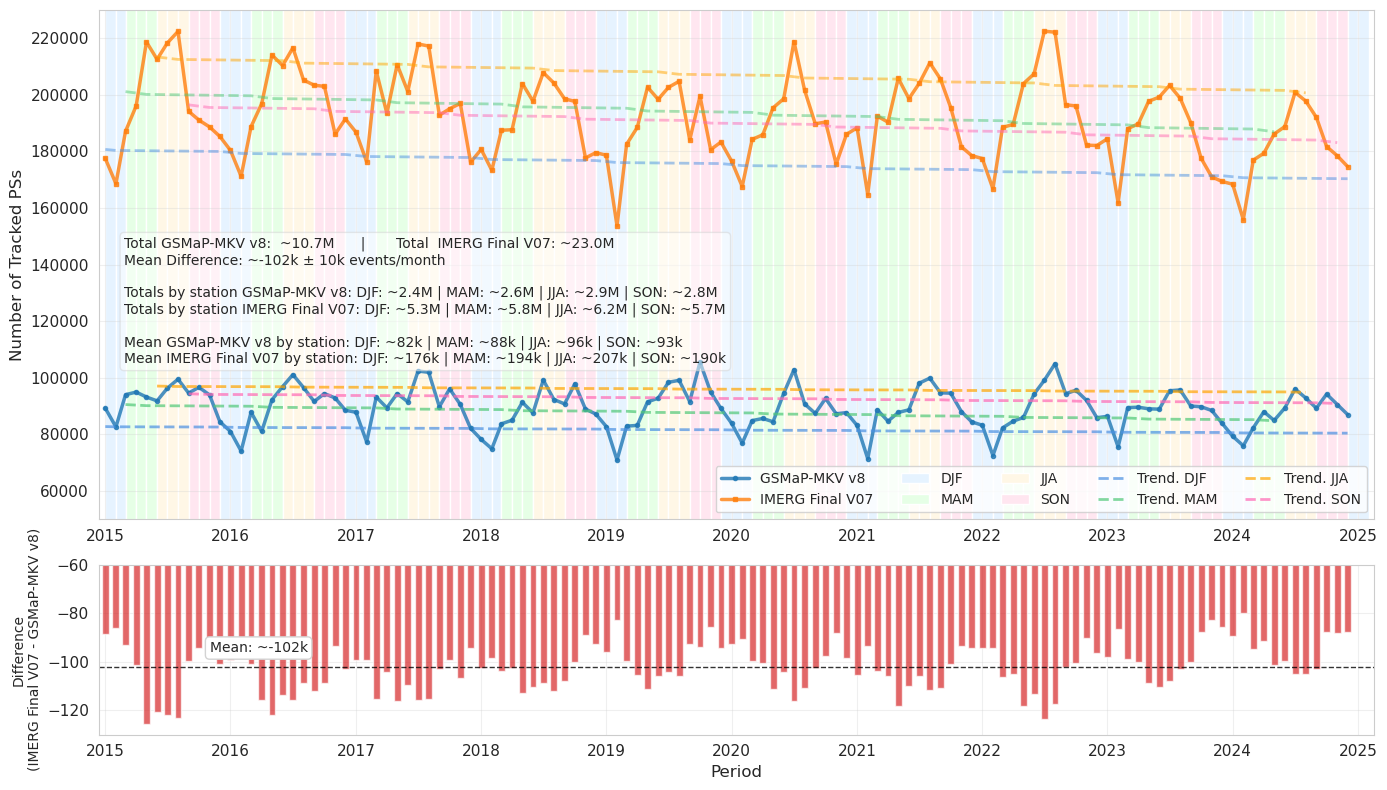

In [26]:
sns.set_style('whitegrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), height_ratios=[3, 1])
# Prepara dados
number_of_events['diff'] = number_of_events['count_gsmap'] - number_of_events['count_imerg']
number_of_events = number_of_events.sort_index()
# Define configurações visuais
season_colors = {'DJF': '#e6f3ff', 'MAM': '#e6ffe6', 'JJA': '#fff7e6', 'SON': '#ffe6f0'}
trend_colors = {'DJF': '#4a90e2', 'MAM': '#50c878', 'JJA': '#ffa500', 'SON': '#ff69b4'}
season_map = {12: 'DJF', 1: 'DJF', 2: 'DJF', 3: 'MAM', 4: 'MAM', 5: 'MAM',
              6: 'JJA', 7: 'JJA', 8: 'JJA', 9: 'SON', 10: 'SON', 11: 'SON'}
# Define limites e datas
extended_start = pd.Timestamp('2014-12-13')
extended_end = pd.Timestamp('2025-02-15')
extended_dates = pd.date_range(extended_start, extended_end, freq='MS')
max_y = number_of_events[['count_gsmap', 'count_imerg']].max().max() * 1.1
# Adiciona fundo colorido das estações
for i in range(len(extended_dates) - 1):
    current_date = extended_dates[i]
    season = season_map[current_date.month]
    ax1.add_patch(mpatches.Rectangle((current_date, 0), extended_dates[i + 1] - current_date, max_y,
                           facecolor=season_colors[season], alpha=1, zorder=0))
# Plota séries principais
ax1.plot(number_of_events.index, number_of_events['count_gsmap'], label=gsmap_name, 
         color='#1f77b4', linewidth=2.5, marker='o', markersize=3, alpha=0.8)
ax1.plot(number_of_events.index, number_of_events['count_imerg'], label=imerg_name, 
         color='#ff7f0e', linewidth=2.5, marker='s', markersize=3, alpha=0.8)
# Adiciona tendências por estação
trend_lines = {}
seasonal_stats = {}
for season in ['DJF', 'MAM', 'JJA', 'SON']:
    season_data = number_of_events[number_of_events['season'] == season]
    x_season = np.arange(len(season_data))
    # Tendência GSMaP
    gsmap_trend_coef = np.polyfit(x_season, season_data['count_gsmap'], 1)
    line = ax1.plot(season_data.index, np.poly1d(gsmap_trend_coef)(x_season), '--', 
                    color=trend_colors[season], alpha=0.7, linewidth=2)[0]
    trend_lines[season] = line
    # Tendência IMERG
    imerg_trend_coef = np.polyfit(x_season, season_data['count_imerg'], 1)
    ax1.plot(season_data.index, np.poly1d(imerg_trend_coef)(x_season), '--', 
             color=trend_colors[season], alpha=0.5, linewidth=2)
    # Salva estatísticas
    seasonal_stats[season] = {
        'gsmap_total': season_data['count_gsmap'].sum(),
        'imerg_total': season_data['count_imerg'].sum(),
        'gsmap_mean': season_data['count_gsmap'].mean(),
        'imerg_mean': season_data['count_imerg'].mean()
    }
# Configurações do gráfico principal
ax1.set_ylim(50000, 230000)
ax1.set_ylabel('Number of Tracked PSs', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='both', labelsize=11)
# Gráfico de diferenças
colors = ['#d62728' if x < 0 else '#2ca02c' for x in number_of_events['diff']]
ax2.bar(number_of_events.index, number_of_events['diff']/1000, color=colors, alpha=0.7, width=20)
mean_diff = number_of_events['diff'].mean()
ax2.axhline(y=mean_diff/1000, color='black', linestyle='--', alpha=0.8, linewidth=1)
ax2.text(number_of_events.index[10], mean_diff/1000 + 5, f'Mean: ~{mean_diff/1000:.0f}k', 
         fontsize=10, ha='left', va='bottom',
         bbox=dict(facecolor='white', alpha=1, edgecolor='lightgray', boxstyle='round,pad=0.3'))
ax2.set_ylim(-130, -60)
ax2.set_ylabel('Difference\n(' + imerg_name + ' - ' + gsmap_name + ')', fontsize=10)
ax2.set_xlabel('Period', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='both', labelsize=11)
# Configuração dos eixos X
for ax in [ax1, ax2]:
    ax.set_xlim(extended_start, extended_end)
    ax.set_xticks(pd.date_range(start=extended_start, end=extended_end, freq='12MS'))
    ax.set_xticklabels([d.strftime('%Y') for d in pd.date_range(extended_start, extended_end, freq='12MS')])
# Legenda
season_patches = [mpatches.Rectangle((0, 0), 1, 1, facecolor=color, alpha=1) for color in season_colors.values()]
handles, labels = ax1.get_legend_handles_labels()
ax1.legend([*handles[:2], *season_patches, *[trend_lines[s] for s in ['DJF', 'MAM', 'JJA', 'SON']]], 
           [gsmap_name, imerg_name, 'DJF', 'MAM', 'JJA', 'SON', 
            'Trend. DJF', 'Trend. MAM', 'Trend. JJA', 'Trend. SON'],
           loc='lower right', ncol=5, fontsize=10)
# Texto de estatísticas
total_gsmap = sum(seasonal_stats[s]['gsmap_total'] for s in seasonal_stats)
total_imerg = sum(seasonal_stats[s]['imerg_total'] for s in seasonal_stats)
std_diff = number_of_events['diff'].std()
stats_text = (f"Total {gsmap_name}:  ~{total_gsmap/1000000:.1f}M      |       Total  {imerg_name}: ~{total_imerg/1000000:.1f}M\n"
              f"Mean Difference: ~{mean_diff/1000:.0f}k ± {std_diff/1000:.0f}k events/month  \n\n"
              f"Totals by station {gsmap_name}: " + " | ".join([f"{s}: ~{seasonal_stats[s]['gsmap_total']/1000000:.1f}M" for s in ['DJF', 'MAM', 'JJA', 'SON']]) + "\n"
              f"Totals by station {imerg_name}: " + " | ".join([f"{s}: ~{seasonal_stats[s]['imerg_total']/1000000:.1f}M" for s in ['DJF', 'MAM', 'JJA', 'SON']]) + "\n\n"
              f"Mean {gsmap_name} by station: " + " | ".join([f"{s}: ~{seasonal_stats[s]['gsmap_mean']/1000:.0f}k" for s in ['DJF', 'MAM', 'JJA', 'SON']]) + "\n"
              f"Mean {imerg_name} by station: " + " | ".join([f"{s}: ~{seasonal_stats[s]['imerg_mean']/1000:.0f}k" for s in ['DJF', 'MAM', 'JJA', 'SON']]))
ax1.text(0.02, 0.3, stats_text, transform=ax1.transAxes, fontsize=10, 
         verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.5, 
         edgecolor='lightgray', boxstyle='round,pad=0.3'))
plt.tight_layout()
plt.show()

#### Figure 5.6 - Global map of the dominant season of PS’s occurrence for each grid cell, based on the maximum seasonal counts.

#### 9.1. Calculate Seasonal System Counts

Compute total precipitation system counts for each season by summing fam-density over all timesteps within each season.

**Calculation Process**:
- **Sum**: Aggregate across time dimension for each season
- **skipna=True**: Ignore missing values (land/ocean masking)
- **compute()**: Execute Dask computation and load into memory

**Output Variables** (8 total):
- `gsmap_jja_fam_count`: GSMaP systems during JJA
- `gsmap_son_fam_count`: GSMaP systems during SON
- `gsmap_djf_fam_count`: GSMaP systems during DJF
- `gsmap_mam_fam_count`: GSMaP systems during MAM
- `imerg_jja_fam_count`: IMERG systems during JJA
- `imerg_son_fam_count`: IMERG systems during SON
- `imerg_djf_fam_count`: IMERG systems during DJF
- `imerg_mam_fam_count`: IMERG systems during MAM

**Interpretation**:
These seasonal totals reveal:
- Geographic patterns of seasonal precipitation maxima
- Monsoon system footprints
- Seasonal migration of convergence zones
- Hemispheric asymmetry in seasonal patterns

In [27]:
# Separate the data into seasons
gsmap_jja = gsmap_ds_v8.sel(time=gsmap_ds_v8['time.season'] == 'JJA')
gsmap_son = gsmap_ds_v8.sel(time=gsmap_ds_v8['time.season'] == 'SON')
gsmap_djf = gsmap_ds_v8.sel(time=gsmap_ds_v8['time.season'] == 'DJF')
gsmap_mam = gsmap_ds_v8.sel(time=gsmap_ds_v8['time.season'] == 'MAM')

imerg_jja = imerg_ds_v7.sel(time=imerg_ds_v7['time.season'] == 'JJA')
imerg_son = imerg_ds_v7.sel(time=imerg_ds_v7['time.season'] == 'SON')
imerg_djf = imerg_ds_v7.sel(time=imerg_ds_v7['time.season'] == 'DJF')
imerg_mam = imerg_ds_v7.sel(time=imerg_ds_v7['time.season'] == 'MAM')

#### 9.2. Visualize Seasonal Distribution Maps

**Figure - Seasonal Precipitation System Distribution**

Create an 8-panel figure showing seasonal system counts for both datasets.

**Figure Layout** (4 rows × 2 columns):
- **Columns**: GSMaP (left), IMERG (right)
- **Rows**: JJA, SON, DJF, MAM (top to bottom)
- **Panel Labels**: (a) through (h)

**Map Configuration**:
- **Projection**: PlateCarree (cylindrical equidistant)
- **Extent**: -60° to 60° latitude, global longitude
- **Colormap**: 'terrain_r' with 20 discrete levels
- **Scale**: 0 to 3,000 systems per grid cell
- **Colorbar**: Shared scale across all panels, labeled "PS Count"
- **Spacing**: Minimal (hspace=0.005, wspace=0.13) for compact layout

**Seasonal Patterns to Observe**:

- **JJA (Austral Winter)**:
  - Maximum in Northern Hemisphere tropics and subtropics
  - Asian monsoon, West African monsoon, North American monsoon
  - Minimum in Southern Hemisphere mid-latitudes

- **SON (Austral Spring)**:
  - Transitional pattern
  - Southern Hemisphere systems increasing
  - ITCZ migrating southward

- **DJF (Austral Summer)**:
  - Maximum in Southern Hemisphere and equatorial regions
  - South American, African, and Australian monsoons
  - North Pacific and Atlantic storm tracks

- **MAM (Austral Autumn)**:
  - Transitional pattern
  - Northern Hemisphere systems increasing
  - ITCZ migrating northward

**Inter-Dataset Comparison**:
Side-by-side panels enable assessment of seasonal pattern agreement and identification of season-specific biases between products.

In [28]:
# Get seasonal family density
gsmap_jja_fam_count= gsmap_jja['fam-density'].sum(dim='time', skipna=True).compute()
gsmap_son_fam_count = gsmap_son['fam-density'].sum(dim='time', skipna=True).compute()
gsmap_djf_fam_count = gsmap_djf['fam-density'].sum(dim='time', skipna=True).compute()
gsmap_mam_fam_count = gsmap_mam['fam-density'].sum(dim='time', skipna=True).compute()
imerg_jja_fam_count = imerg_jja['fam-density'].sum(dim='time', skipna=True).compute()
imerg_son_fam_count = imerg_son['fam-density'].sum(dim='time', skipna=True).compute()
imerg_djf_fam_count = imerg_djf['fam-density'].sum(dim='time', skipna=True).compute()
imerg_mam_fam_count = imerg_mam['fam-density'].sum(dim='time', skipna=True).compute()

[########################################] | 100% Completed | 2.06 sms
[########################################] | 100% Completed | 2.08 s
[########################################] | 100% Completed | 2.16 s
[########################################] | 100% Completed | 2.26 s
[########################################] | 100% Completed | 2.28 s
[########################################] | 100% Completed | 2.28 s
[########################################] | 100% Completed | 2.38 s
[########################################] | 100% Completed | 1.99 sms
[########################################] | 100% Completed | 2.09 s
[########################################] | 100% Completed | 2.09 s
[########################################] | 100% Completed | 2.18 s
[########################################] | 100% Completed | 2.19 s
[########################################] | 100% Completed | 2.28 s
[########################################] | 100% Completed | 2.29 s
[#############################

<a id='dominant'></a>
### Part 5: Dominant Season Analysis

This section identifies which season experiences the maximum precipitation system activity at each grid location, revealing regional precipitation climatology.

#### 10. Calculate Seasonal Fractions

Compute the fractional contribution of each season to total annual system counts.

**Calculation**:
- **Formula**: seasonal_fraction = seasonal_count / total_annual_count
- **Range**: 0 to 1 (or 0% to 100%)
- **Interpretation**: 
  - 0.25 = uniform distribution across seasons
  - > 0.25 = above-average activity in that season
  - < 0.25 = below-average activity

**Variables Created** (8 fractions × 2 datasets):
- GSMaP: `gsmap_frac_jja`, `gsmap_frac_son`, `gsmap_frac_djf`, `gsmap_frac_mam`
- IMERG: `imerg_frac_jja`, `imerg_frac_son`, `imerg_frac_djf`, `imerg_frac_mam`

**Purpose**:
Fractional analysis normalizes for total system count, enabling fair comparison of seasonal patterns between regions with different total precipitation system frequencies.

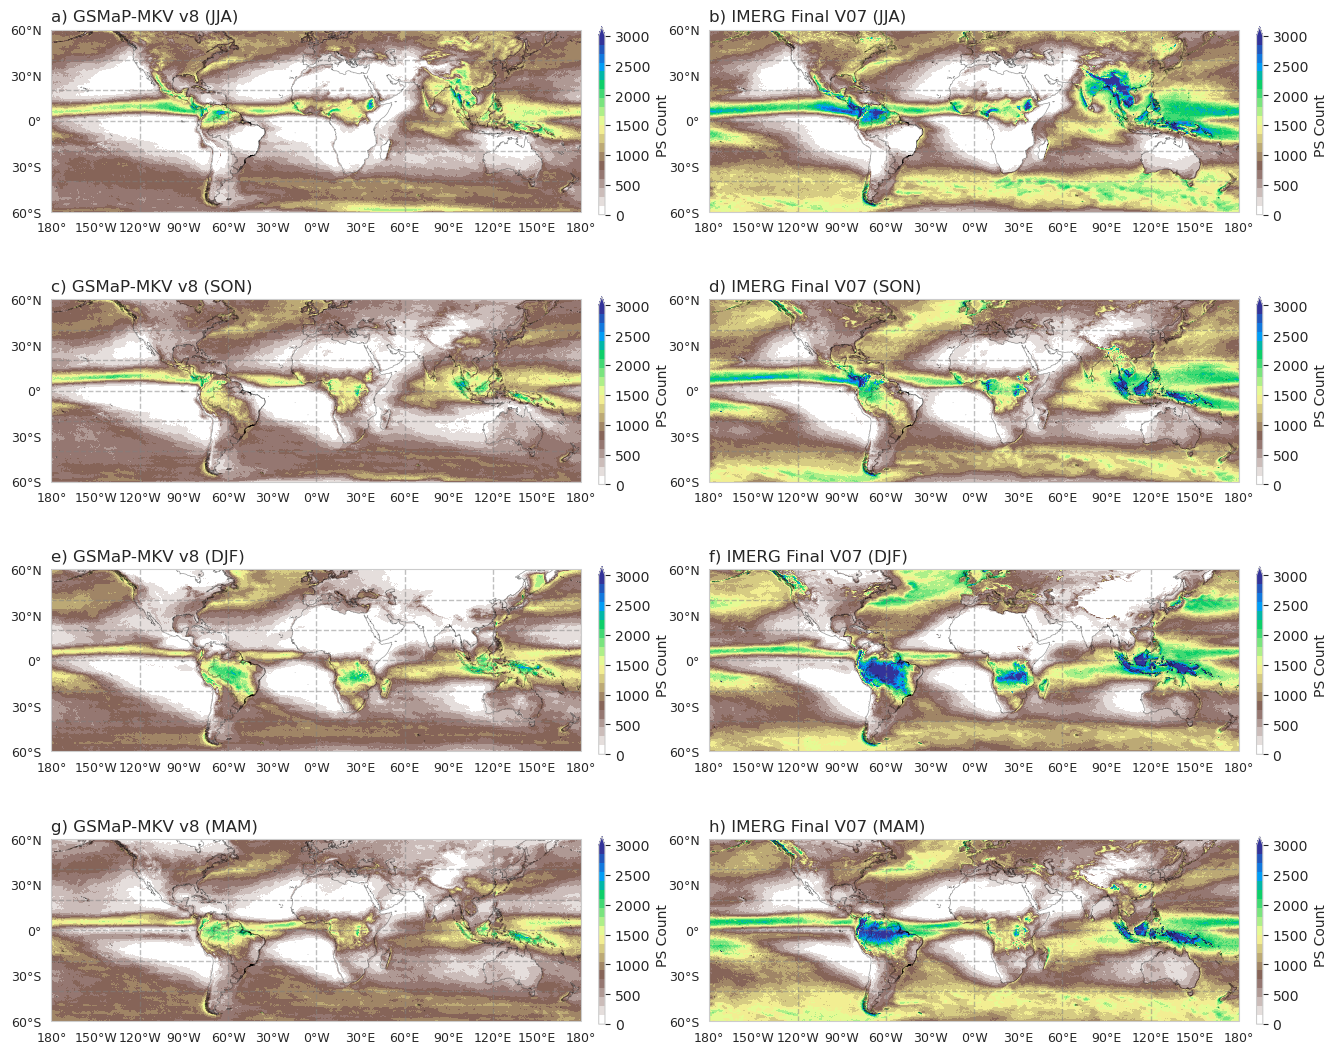

In [29]:
# Figure that shows family density by season
fig, axes = plt.subplots(4, 2, figsize=(16, 14), dpi=100, subplot_kw={'projection': cartopy.crs.PlateCarree()},
                                                          gridspec_kw={'hspace': 0.005, 'wspace': 0.13})
plots.map(gsmap_jja_fam_count, figsize=(12, 12), ax=axes[0,0], title='', ylim=[-60, 60], cmap_num=20, cmap='terrain_r', max_val=3000, cbar_extend='max', cbar_fraction=0.06,  cbar_shrink=0.7, cbar_label='PS Count')
plots.map(imerg_jja_fam_count, figsize=(12, 12), ax=axes[0,1], title='', ylim=[-60, 60], cmap_num=20, cmap='terrain_r', max_val=3000, cbar_extend='max', cbar_fraction=0.06,  cbar_shrink=0.7, cbar_label='PS Count')
plots.map(gsmap_son_fam_count, figsize=(12, 12), ax=axes[1,0], title='', ylim=[-60, 60], cmap_num=20, cmap='terrain_r', max_val=3000, cbar_extend='max', cbar_fraction=0.06,  cbar_shrink=0.7, cbar_label='PS Count')
plots.map(imerg_son_fam_count, figsize=(12, 12), ax=axes[1,1], title='', ylim=[-60, 60], cmap_num=20, cmap='terrain_r', max_val=3000, cbar_extend='max', cbar_fraction=0.06,  cbar_shrink=0.7, cbar_label='PS Count')
plots.map(gsmap_djf_fam_count, figsize=(12, 12), ax=axes[2,0], title='', ylim=[-60, 60], cmap_num=20, cmap='terrain_r', max_val=3000, cbar_extend='max', cbar_fraction=0.06,  cbar_shrink=0.7, cbar_label='PS Count')
plots.map(imerg_djf_fam_count, figsize=(12, 12), ax=axes[2,1], title='', ylim=[-60, 60], cmap_num=20, cmap='terrain_r', max_val=3000, cbar_extend='max', cbar_fraction=0.06,  cbar_shrink=0.7, cbar_label='PS Count')
plots.map(gsmap_mam_fam_count, figsize=(12, 12), ax=axes[3,0], title='', ylim=[-60, 60], cmap_num=20, cmap='terrain_r', max_val=3000, cbar_extend='max', cbar_fraction=0.06,  cbar_shrink=0.7, cbar_label='PS Count')
plots.map(imerg_mam_fam_count, figsize=(12, 12), ax=axes[3,1], title='', ylim=[-60, 60], cmap_num=20, cmap='terrain_r', max_val=3000, cbar_extend='max', cbar_fraction=0.06,  cbar_shrink=0.7, cbar_label='PS Count')
axes[0,0].set_title(f"a) {gsmap_name} (JJA)", loc='left', y=1)
axes[0,1].set_title(f"b) {imerg_name} (JJA)", loc='left', y=1)
axes[1,0].set_title(f"c) {gsmap_name} (SON)", loc='left', y=1)
axes[1,1].set_title(f"d) {imerg_name} (SON)", loc='left', y=1)
axes[2,0].set_title(f"e) {gsmap_name} (DJF)", loc='left', y=1)
axes[2,1].set_title(f"f) {imerg_name} (DJF)", loc='left', y=1)
axes[3,0].set_title(f"g) {gsmap_name} (MAM)", loc='left', y=1)
axes[3,1].set_title(f"h) {imerg_name} (MAM)", loc='left', y=1);

In [30]:
# GSMAP fraction by season
gsmap_frac_jja = gsmap_jja_fam_count / gsmap_fam_count
gsmap_frac_son = gsmap_son_fam_count / gsmap_fam_count
gsmap_frac_djf = gsmap_djf_fam_count / gsmap_fam_count
gsmap_frac_mam = gsmap_mam_fam_count / gsmap_fam_count
# IMERG fraction by season
imerg_frac_jja = imerg_jja_fam_count / imerg_fam_count
imerg_frac_son = imerg_son_fam_count / imerg_fam_count
imerg_frac_djf = imerg_djf_fam_count / imerg_fam_count
imerg_frac_mam = imerg_mam_fam_count / imerg_fam_count

#### 10.1. Identify Dominant Season per Grid Cell

Determine which season has maximum precipitation system activity at each spatial location.

**Processing Steps**:

1. **Concatenate Seasonal Fractions**:
   - Combine the four seasonal fractions into a single DataArray
   - Create new dimension: 'season' with labels ['DJF', 'MAM', 'JJA', 'SON']
   - Maintains spatial dimensions (lat, lon)

2. **Find Maximum Season**:
   - Use `.argmax(dim='season')` to find index of maximum value
   - Returns integer: 0=DJF, 1=MAM, 2=JJA, 3=SON
   - Creates categorical map of dominant seasons

**Output Variables**:
- `gsmap_estacao_dominante`: GSMaP dominant season map (integer coded)
- `imerg_estacao_dominante`: IMERG dominant season map (integer coded)

**Interpretation**:
The resulting maps show regional precipitation seasonality:
- Which season dominates at each location
- Monsoon system extents and timing
- Seasonal migration zones (ITCZ, convergence zones)
- Hemispheric differences in seasonal patterns

In [39]:
# Union of seasonal fractions into a single DataArray
gsmap_frac_seasons = xr.concat([gsmap_frac_djf, gsmap_frac_mam, gsmap_frac_jja, gsmap_frac_son], dim='season')
gsmap_frac_seasons = gsmap_frac_seasons.assign_coords(season=['DJF', 'MAM', 'JJA', 'SON'])
imerg_frac_seasons = xr.concat([ imerg_frac_djf, imerg_frac_mam, imerg_frac_jja, imerg_frac_son], dim='season')
imerg_frac_seasons = imerg_frac_seasons.assign_coords(season=['DJF', 'MAM', 'JJA', 'SON'])

# Dominant season for each pixel based on maximum argument position
gsmap_estacao_dominante = gsmap_frac_seasons.argmax(dim='season')
imerg_estacao_dominante = imerg_frac_seasons.argmax(dim='season')

#### 10.2. Visualize Dominant Season Maps

**Figure 5.6 - Dominant Season of Precipitation System Occurrence**

Create a two-panel map showing which season experiences maximum PS activity at each grid location.

**Map Configuration**:
- **Panel (a)**: GSMaP-MKV v8 dominant season
- **Panel (b)**: IMERG Final V07 dominant season
- **Extent**: -60° to 60° latitude, global coverage

**Color Coding**:
- **DJF**: Color C8 (Austral summer / Boreal winter)
- **MAM**: Color C0 (Austral autumn / Boreal spring)
- **JJA**: Color C2 (Austral winter / Boreal summer)
- **SON**: Color C3 (Austral spring / Boreal autumn)

**Legend**:
- Four colored patches representing the seasons
- Positioned at upper center, below the maps
- Horizontal layout (ncol=4)

**No Colorbar**: Categorical data, legend sufficient

**Regional Patterns to Identify**:

1. **Tropical Regions**:
   - Equatorial: Often DJF or bimodal patterns
   - Northern tropics: JJA (Asian, African, American monsoons)
   - Southern tropics: DJF (South American, African, Australian monsoons)

2. **Subtropical Regions**:
   - Clear hemispheric asymmetry
   - Summer-dominant precipitation (respective hemispheres)

3. **Mid-latitudes**:
   - More complex patterns
   - Storm track influences
   - Transitional seasons may dominate

4. **Inter-Dataset Agreement**:
   - Comparison reveals regions where products agree/disagree on seasonality
   - Potential algorithm-dependent seasonal biases

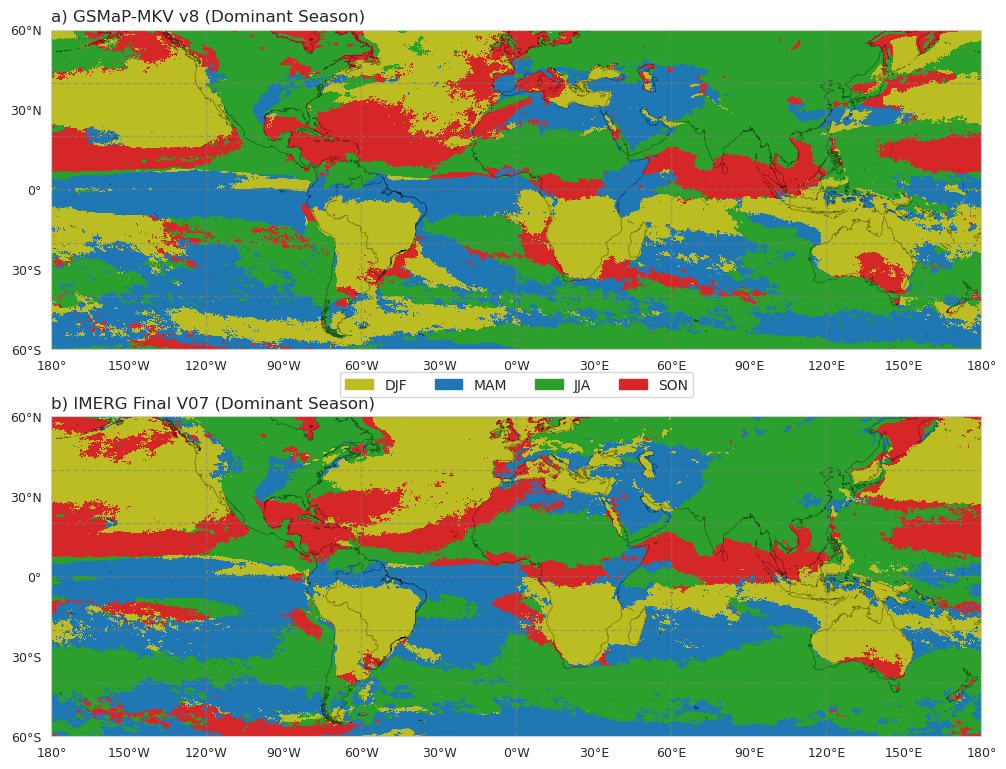

In [43]:
cmap = mcolors.ListedColormap(["C8", "C0", "C2", "C3"])
seasons = ['DJF', 'MAM', 'JJA', 'SON']
colors = [cmap(i) for i in range(4)]
patches = [mpatches.Patch(color=colors[i], label=seasons[i]) for i in range(4)]
fig, axes = plt.subplots(2, 1, figsize=(12, 10), dpi=100, subplot_kw={'projection': cartopy.crs.PlateCarree()},
                                                          gridspec_kw={'hspace': 0.01, 'wspace': 0.13})
plots.map(gsmap_estacao_dominante, figsize=(12, 12), ax=axes[0], title='', ylim=[-60, 60], cmap_num=4, cmap=cmap,  
          cbar_extend='neither', cbar_fraction=0.06,  cbar_shrink=0.7, cbar=False)
plots.map(imerg_estacao_dominante, figsize=(12, 12), ax=axes[1], title='', ylim=[-60, 60], cmap_num=4, cmap=cmap, 
            cbar_extend='neither', cbar_fraction=0.06,  cbar_shrink=0.7, cbar=False)
axes[0].set_title(f"a) {gsmap_name} (Dominant Season)", loc='left', y=1)
axes[1].set_title(f"b) {imerg_name} (Dominant Season)", loc='left', y=1)
axes[0].legend(handles=patches, loc='upper center', fontsize=10, bbox_to_anchor=(0.5, -0.05), ncol=4)

<a id='hovmoller'></a>
### Part 6: Latitudinal-Temporal Analysis

This section examines the latitudinal distribution and temporal evolution of precipitation systems using Hovmöller diagrams.

#### 11. Define Hovmöller Diagram Function

Create a custom function to generate Hovmöller (time-latitude) diagrams from tracking data.

**Function: `hovmoller(table, file, con)`**

**Purpose**: Extract and aggregate precipitation system occurrences by latitude band and month for visualization of meridional migration patterns.

**Processing Steps**:

1. **Check Cache**: If output file exists, load and return (avoid recomputation)

2. **Create Temporary Tables**:
   - `uid_cindex`: Extract first (min_cindex) and last (max_cindex) observation indices for each system
   - `uid_geoms`: Join geometry data for system initiation and termination points

3. **Calculate Representative Latitude**:
   - Extract centroid latitude at first and last observations
   - Compute mean latitude: `(first_lat + last_lat) / 2`
   - Bin latitude to nearest degree: `FLOOR(mean_lat)`

4. **Filter and Export**:
   - Restrict to -60° to 60° latitude range
   - Select: uid, min_timestamp (system start), lat_bin
   - Export to parquet for efficient storage

**Output**: DataFrame with columns:
- `uid`: Unique system identifier
- `min_timestamp`: System initiation time
- `lat_bin`: Latitude bin (integer degrees)

**Usage**: Called separately for GSMaP and IMERG tracking tables to enable comparative Hovmöller analysis.

#### Figure 5.8 - Hovmöller diagrams showing the latitudinal distribution of monthly PS counts.

#### 11.1. Generate Hovmöller Data

Execute the hovmöller function for both datasets to create latitude-time aggregated data.

**Function Calls**:
- GSMaP: `hovmoller('gsmap_tracking', 'queries/hovmoller/gsmap.parquet', con)`
- IMERG: `hovmoller('imerg_tracking', 'queries/hovmoller/imerg.parquet', con)`

**Processing**:
If cached files don't exist, the function:
1. Queries the database to extract system geometries
2. Calculates representative latitudes
3. Bins systems by latitude and month
4. Saves results to parquet files

**Output Files**:
- `queries/hovmoller/gsmap.parquet`: GSMaP Hovmöller data
- `queries/hovmoller/imerg.parquet`: IMERG Hovmöller data

**Performance**: 
- Caching mechanism significantly speeds up subsequent runs
- Database queries optimized for large datasets
- Parquet format provides efficient compression and fast loading

In [52]:
def hovmoller(table, file, con):
    # If file exist open and return
    if os.path.exists(file):
      return pd.read_parquet(file)
    # Create dir and generat file
    os.makedirs(os.path.dirname(file), exist_ok=True)
    # 1 - Create a table with min and max cindex for each uid
    con.execute(f"""
        CREATE OR REPLACE TEMP TABLE uid_cindex AS
        SELECT 
            uid,
            MIN(cindex) AS min_cindex,
            MAX(cindex) AS max_cindex
        FROM {table}
        GROUP BY uid;
    """)
    # 2 - Create a table with geometries for min and max cindex
    con.execute(f"""
        CREATE OR REPLACE TEMP TABLE uid_geoms AS
        SELECT t.uid, t.cindex, t.geometry, t.timestamp, u.min_cindex, u.max_cindex
        FROM {table} t
        JOIN uid_cindex u ON t.uid = u.uid 
         AND (t.cindex = u.min_cindex OR t.cindex = u.max_cindex);
    """)
    # 3 - Create the hovmoller table and export to parquet
    con.execute(f"""
        COPY (
            WITH first_last AS (
                SELECT 
                    uid,
                    MIN(timestamp) AS min_timestamp,
                    MAX(timestamp) AS max_timestamp,
                    MAX(CASE WHEN cindex = min_cindex 
                             THEN ST_Y(ST_Centroid(ST_GeomFromText(geometry))) END) AS first_lat,
                    MAX(CASE WHEN cindex = max_cindex 
                             THEN ST_Y(ST_Centroid(ST_GeomFromText(geometry))) END) AS last_lat
                FROM uid_geoms
                GROUP BY uid
            )
            SELECT 
                uid, min_timestamp, FLOOR((first_lat + last_lat) / 2.0) AS lat_bin
            FROM first_last
            WHERE lat_bin BETWEEN -60 AND 60
        ) TO '{file}' (FORMAT PARQUET);
    """)
    return pd.read_parquet(file)

#### 11.2. Prepare Hovmöller Data for Visualization

Transform the latitude-binned system data into a format suitable for heatmap visualization.

**Processing Steps for Both Datasets**:

1. **Extract Month**: 
   - Create 'mes' column from `min_timestamp.dt.month`
   - Values: 1-12 representing January-December

2. **Ensure Integer Latitude**:
   - Convert 'lat_bin' to integer type
   - Ensures proper sorting and indexing

3. **Count Systems per Bin**:
   - Group by month and latitude bin
   - Count unique system IDs (`.nunique()`)
   - Aggregates all systems occurring in each month-latitude cell

4. **Pivot to Matrix Form**:
   - Rows: Latitude bins (-60 to 60)
   - Columns: Months (1-12)
   - Values: System counts
   - Fill missing values with 0

5. **Sort Latitudes Descending**:
   - `sort_index(ascending=False)` arranges from 60°N to 60°S
   - Matches conventional Hovmöller diagram orientation (North at top)

**Output DataFrames**:
- `gsmap_hovmoller`: 121 rows (latitudes) × 12 columns (months)
- `imerg_hovmoller`: 121 rows (latitudes) × 12 columns (months)

**Ready for Plotting**: Matrix format is ideal for seaborn heatmap visualization.

In [53]:
# Hovmoller data
gsmap_hovmoller = hovmoller('gsmap_tracking', 'queries/hovmoller/gsmap.parquet', con)
imerg_hovmoller = hovmoller('imerg_tracking', 'queries/hovmoller/imerg.parquet', con)

#### 11.3. Visualize Hovmöller Diagrams

**Figure 5.8 - Latitudinal-Temporal Distribution of Precipitation Systems**

Create side-by-side Hovmöller diagrams showing the latitudinal migration of precipitation systems throughout the year.

**Figure Layout**:
- **Two Panels**: GSMaP (left), IMERG (right)
- **Size**: 12×5 inches
- **Shared Axes**: Common latitude (y) and month (x) scales

**Heatmap Configuration**:
- **Colormap**: 'YlGnBu' (yellow-green-blue sequential)
- **Scale**: 4,000 to 30,000 systems
- **No Colorbar on Individual Panels**: Shared colorbar on right
- **Aspect**: Non-square to emphasize temporal evolution

**Axes Configuration**:

- **X-axis (Months)**:
  - Labels: Jan, Feb, Mar, ..., Dec (abbreviated)
  - Rotated 45° for readability
  - Centered on month midpoints

- **Y-axis (Latitude)**:
  - Range: 60°N to 60°S (top to bottom)
  - Labels shown on left panel only
  - Unit: Degrees

**Seasonal Annotations**:
- **Vertical Dashed Lines**: Separate seasons (at months 2, 5, 8, 11)
- **Season Labels**: DJF, MAM, JJA, SON, DJF above diagram
  - Bold font weight
  - Positioned at y=1.02 (above x-axis)

**Shared Colorbar**:
- **Position**: Right side (0.9, 0.175, 0.01, 0.6)
- **Ticks**: Every 1,500 systems (labeled in 'k' notation)
- **Label**: "PS Count"
- **Extend**: Both directions (indicates values beyond range)

**Interpretation Patterns**:

1. **ITCZ Migration**:
   - Seasonal north-south oscillation near equator
   - Follows solar declination

2. **Monsoon Systems**:
   - Summer maxima in respective hemispheres
   - Clear seasonal onset and retreat

3. **Mid-latitude Storm Tracks**:
   - Persistent activity at ~40-60° in both hemispheres
   - Winter intensification

4. **Inter-hemispheric Asymmetry**:
   - Different patterns between Northern and Southern hemispheres
   - Land-ocean distribution effects

5. **Dataset Comparison**:
   - Agreement in major features
   - Potential differences in magnitude or precise latitude

In [54]:
# GSMAP Prepare hovmoller data for plotting
gsmap_hovmoller['mes'] = gsmap_hovmoller['min_timestamp'].dt.month
gsmap_hovmoller['lat_bin'] = gsmap_hovmoller['lat_bin'].astype(int)
gsmap_hovmoller = gsmap_hovmoller.groupby(['mes', 'lat_bin'])['uid'].nunique().reset_index()
gsmap_hovmoller = gsmap_hovmoller.pivot(index='lat_bin', columns='mes', values='uid').fillna(0)
gsmap_hovmoller = gsmap_hovmoller.sort_index(ascending=False) # Sort lat_bin from 60 to -60
# IMERG Prepare hovmoller data for plotting
imerg_hovmoller['mes'] = imerg_hovmoller['min_timestamp'].dt.month
imerg_hovmoller['lat_bin'] = imerg_hovmoller['lat_bin'].astype(int)
imerg_hovmoller = imerg_hovmoller.groupby(['mes', 'lat_bin'])['uid'].nunique().reset_index()
imerg_hovmoller = imerg_hovmoller.pivot(index='lat_bin', columns='mes', values='uid').fillna(0)
imerg_hovmoller = imerg_hovmoller.sort_index(ascending=False) # Sort lat from 60 to -60

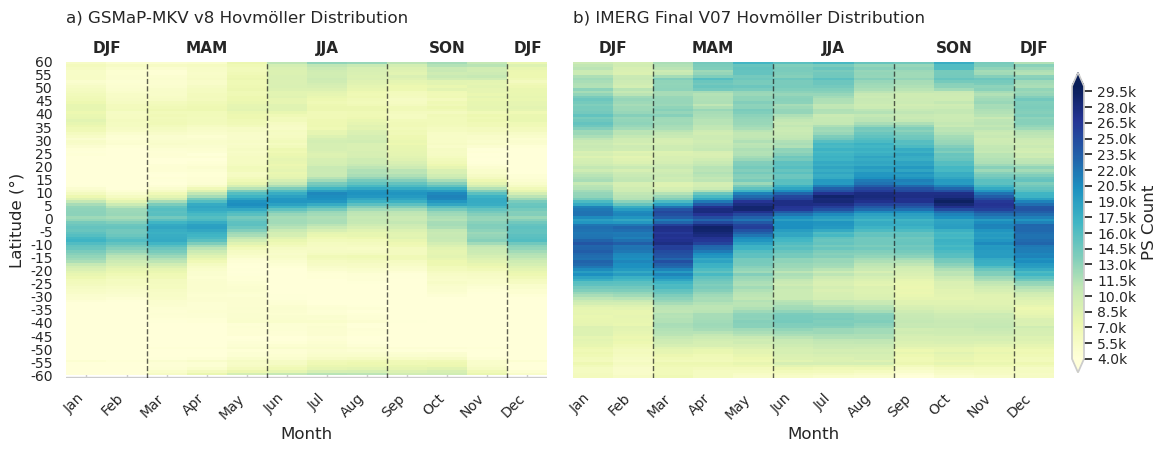

In [56]:
sns.set(style="whitegrid")
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), sharey=True, sharex=True)
hm_gsmap = sns.heatmap(gsmap_hovmoller, ax=axs[0], cmap="YlGnBu", cbar=False, square=False, vmin=4000, vmax=30000)
hm_imerg = sns.heatmap(imerg_hovmoller, ax=axs[1], cmap="YlGnBu", cbar=False, square=False, vmin=4000, vmax=30000)
for i in range(2):
    axs[i].set_title(f"{'a) ' if i==0 else 'b) '}{gsmap_name if i==0 else imerg_name} Hovmöller Distribution", loc='left', y=1.1)
    axs[i].set_xlabel('Month', fontsize=12)
    axs[i].set_ylabel('Latitude', fontsize=12)
    axs[i].set_xticks(np.arange(0.5, 12.5), labels=[str(m) for m in range(1, 13)])
    axs[i].axvline(2, color='k', linestyle='--', linewidth=1, alpha=0.7)
    axs[i].axvline(5, color='k', linestyle='--', linewidth=1, alpha=0.7)
    axs[i].axvline(8, color='k', linestyle='--', linewidth=1, alpha=0.7)
    axs[i].axvline(11, color='k', linestyle='--', linewidth=1, alpha=0.7)
    y_pos = 1.02
    axs[i].text(1, y_pos, 'DJF', ha='center', va='bottom', transform=axs[i].get_xaxis_transform(), fontsize=11, weight='bold')
    axs[i].text(3.5, y_pos, 'MAM', ha='center', va='bottom', transform=axs[i].get_xaxis_transform(), fontsize=11, weight='bold')
    axs[i].text(6.5, y_pos, 'JJA', ha='center', va='bottom', transform=axs[i].get_xaxis_transform(), fontsize=11, weight='bold')
    axs[i].text(9.5, y_pos, 'SON', ha='center', va='bottom', transform=axs[i].get_xaxis_transform(), fontsize=11, weight='bold')
    axs[i].text(11.5, y_pos, 'DJF', ha='center', va='bottom', transform=axs[i].get_xaxis_transform(), fontsize=11, weight='bold')
    axs[i].set_xticks([x + 0.5 for x in range(12)])
    axs[i].set_xticklabels([calendar.month_abbr[m] for m in range(1, 13)], rotation=45, ha='right', fontsize=10)
    axs[i].set_xlabel("Month", fontsize=12)
    if i == 0:
        axs[i].set_ylabel("Latitude (°)", fontsize=12)
        axs[i].set_yticklabels(axs[i].get_yticklabels(), fontsize=10)
    else:
        axs[i].set_ylabel("")
# Configuração da barra de cores
cax = fig.add_axes([0.9, 0.175, 0.01, 0.6])
cbar1 = fig.colorbar(hm_gsmap.collections[0], cax=cax, use_gridspec=False, orientation='vertical', extend='both')
cbar1.set_ticks(np.arange(4000, 30000, 1500))
cbar1.set_ticklabels([f"{(tick/1000)}k" for tick in cbar1.get_ticks()])
cbar1.ax.tick_params(labelsize=10)
cbar1.set_label('PS Count', fontsize=12)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()